# Model training based on near-boundary points

## Train a neural network with classical binary cross entropy loss

We have obtained a set of data points that are close to the actual basin boundary(error margin $\delta$ = 0.01). We use this dataset to train a neural network for classification.

In [19]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [20]:
## Load the dataset
class LorenzDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor([self.data.iloc[idx].x0, self.data.iloc[idx].y0, self.data.iloc[idx].z0]).float()
        label = torch.tensor(self.data.iloc[idx].attracted).float()
        return features, label
    
dataset = LorenzDataset('dataset_near.csv')

dataset_train, dataset_test = torch.utils.data.random_split(dataset, [16000, 4000])

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [21]:
## Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3,128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
net = Net()

In [15]:
## Set up loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [22]:
# Check if MPS is available and set the device accordingly
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:
# Move the model to the device
net = net.to(device)
criterion.to(device)

## Train the network
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    mini_batch_count = 0
    for features, labels in dataset_train:
        # Ensure features is a Tensor
        if not isinstance(features, torch.Tensor):
            features = torch.Tensor(features)

        # Ensure labels is a Tensor
        if not isinstance(labels, torch.Tensor):
            labels = torch.Tensor(labels)

        # Convert labels from -1 or 1 to 0 or 1
        labels = ((labels + 1) / 2).float()

        # Reshape labels to match the output shape
        labels = labels.view(-1)

        # Move the features and labels to the device
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        mini_batch_count += 1
        if mini_batch_count % 1000 == 0:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, mini_batch_count, running_loss / 1000))
            running_loss = 0.0
    print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / len(dataset_train)))

[1,  1000] loss: 0.775
[1,  2000] loss: 0.770
[1,  3000] loss: 0.807
[1,  4000] loss: 0.798
[1,  5000] loss: 0.794
[1,  6000] loss: 0.756
[1,  7000] loss: 0.778
[1,  8000] loss: 0.766
[1,  9000] loss: 0.759
[1, 10000] loss: 0.762
[1, 11000] loss: 0.772
[1, 12000] loss: 0.781
[1, 13000] loss: 0.763
[1, 14000] loss: 0.780
[1, 15000] loss: 0.797
[1, 16000] loss: 0.766
Finished training for epoch 1, loss: 0.000
[2,  1000] loss: 0.775
[2,  2000] loss: 0.770
[2,  3000] loss: 0.807
[2,  4000] loss: 0.798
[2,  5000] loss: 0.794
[2,  6000] loss: 0.756
[2,  7000] loss: 0.778
[2,  8000] loss: 0.766
[2,  9000] loss: 0.759
[2, 10000] loss: 0.762
[2, 11000] loss: 0.772
[2, 12000] loss: 0.781
[2, 13000] loss: 0.763
[2, 14000] loss: 0.780
[2, 15000] loss: 0.797
[2, 16000] loss: 0.766
Finished training for epoch 2, loss: 0.000
[3,  1000] loss: 0.775
[3,  2000] loss: 0.770
[3,  3000] loss: 0.807
[3,  4000] loss: 0.798
[3,  5000] loss: 0.794
[3,  6000] loss: 0.756
[3,  7000] loss: 0.778
[3,  8000] loss: 

KeyboardInterrupt: 

Accuracy: 0.5024999976158142


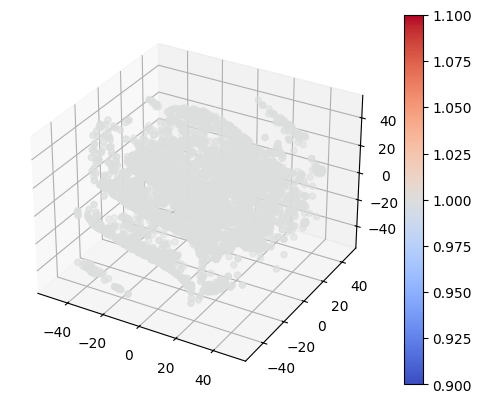

In [ ]:
## Test the network and plot the results
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

features_list = []
labels_list = []
predictions_list = []
acc = Accuracy(task = 'binary')

dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

with torch.no_grad():
    for features, labels in dataloader_test:
        features = features.to(device)
        labels = labels.to(device)
        labels = ((labels + 1) / 2).float()
        outputs = (net(features) >= 0.5).float()
        outputs = outputs.squeeze(0)

        acc.update(outputs, labels)

        # Move features, labels, and outputs to CPU and convert them to numpy arrays
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        predictions_list.append(outputs.cpu().numpy())
accuracy = acc.compute()
print(f'Accuracy: {accuracy}')

# Concatenate all batches
features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)
predictions = np.concatenate(predictions_list, axis=0)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features colored by the predictions
scatter = ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=predictions, cmap='coolwarm')

# Add a color bar
plt.colorbar(scatter)

plt.show()